In [56]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
RS = 18

In [62]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid")
import scikitplot.metrics as skpm

In [95]:
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE # focus en las samples cerca de la frontera
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline

from sklearn.feature_selection import VarianceThreshold # low or 0 variance
from sklearn.feature_selection import SelectKBest       # univariate, based on function
from sklearn.feature_selection import SelectPercentile 
from sklearn.feature_selection import chi2, f_classif   # use with SelectKBest y SelectPercentile
from sklearn.feature_selection import RFECV             # recursive method

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.base import TransformerMixin, BaseEstimator
#from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.compose import ColumnTransformer
#from custom_transformers import *

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.impute import SimpleImputer

## Funciones

In [5]:
def plot_target_prop(y, tit='y'):
    """
    Input: vector y de respuestas
    Return: plot con la distribucion de las clases
    """
    vc = y.value_counts(normalize=True)
    y.value_counts().plot(kind='bar', title=f'{tit} - Proporción de Clases:\n0:{vc[0]:.3f} / 1:{vc[1]:.3f}')
    plt.tight_layout
    plt.show()
    return 

## Custom Transformers

In [6]:
class DatetimeFromUnixTimestamp(BaseEstimator, TransformerMixin):
    """
    Return a df from a df with columns with unix timestamps as string
    """
    
    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xdate = X.apply(lambda s: pd.to_datetime(s, unit='s'))
        return Xdate

In [7]:
class SparseToDense(BaseEstimator, TransformerMixin):
    """
    Return a dense matrix from a sparse matrix
    """
    
    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a sparse matrix
        Xdate = X.todense()
        return Xdate

In [8]:
class DateEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        dfs = []
        self.column_names = []
        for column in X:
            dt = X[column].dt
            # Assign custom column names
            newcolumnnames = [column+'_'+col for col in ['dia', 'hora']]
            df_dt = pd.concat([dt.dayofweek, dt.hour], axis=1)
            # Append DF to list to assemble list of DFs
            dfs.append(df_dt)
            # Append single DF's column names to blank list
            self.column_names.append(newcolumnnames)
        # Horizontally concatenate list of DFs
        dfs_dt = pd.concat(dfs, axis=1)
        dfs_dt.columns = self.column_names
        return dfs_dt

    #def get_feature_names(self):
        # Flatten list of column names
        #self.column_names = [c for sublist in self.column_names for c in sublist]
        #return self.column_names

### Lectura de Dataset

In [9]:
X = pd.read_csv('data.csv', index_col=0)

In [10]:
X.head()

,Label,action_categorical_0,action_categorical_1,action_categorical_2,action_categorical_3,action_categorical_4,action_categorical_5,action_categorical_6,action_categorical_7,action_list_0,...,creative_categorical_7,creative_categorical_8,creative_categorical_9,creative_height,creative_width,device_id,device_id_type,gender,has_video,timezone_offset
501207,0,9915ffee,dc24b79b,7c0ac8b2,7ce4e1a3,c96ff6e9,6bc0e29c,59638795,e2538fca,IAB22-2,...,NaN,b6910b48,65dcab89,50.0,320.0,f0fa3c6a,c1d12c8e,NaN,False,1.0
4161173,0,9915ffee,d9eb38d8,9a115291,9ebdf82c,39fd7da2,6bc0e29c,59638795,31b31f57,IAB22-2,...,NaN,b6910b48,65dcab89,50.0,320.0,bfeb7f99,6324b367,m,False,1.0
7192211,0,c2e4f717,3074db21,1ae7a73f,62c903fc,9715f8a7,6bc0e29c,59638795,e2538fca,IAB20-6,...,NaN,b6910b48,65dcab89,50.0,320.0,a80b39cc,c1d12c8e,NaN,False,1.0
2031957,0,c2e4f717,3074db21,1ae7a73f,62c903fc,526e989d,6bc0e29c,59638795,e2538fca,IAB20-6,...,NaN,b6910b48,65dcab89,50.0,320.0,18afe0ec,c1d12c8e,m,False,1.0
2062667,0,c202ab08,6d1ca31b,75f68f1d,93071c6b,4db148d9,6bc0e29c,59638795,e2538fca,IAB8-9,...,NaN,b6910b48,65dcab89,50.0,320.0,f42d4474,c1d12c8e,m,False,1.0


### Feature Engineering

#### Eliminar Features

In [11]:
# features con listas
X.drop(['action_list_1', 'action_list_2', 'auction_list_0'], axis=1, inplace=True)
# features con excesivos nans
X.drop(['gender'], axis=1, inplace=True)

#### Modificar Features

In [12]:
# auction_age: Reemplazar valores de edad  <10 y >80 por np.nan
X.loc[(X.auction_age < 10) | (X.auction_age > 80), ['auction_age']] = np.nan

#### Separar features categóricas de numéricas  
Incluye una separación entre categóricas con alta cardinalidad, para aquellas que tienen >20 clases diferentes

In [13]:
num_cols = []
cat_cols = []
hccat_cols = []
bool_cols = []

for col_name in X.columns:
    if (X[col_name].dtype == 'object'):      
        X[col_name] = X[col_name].astype('str')
        if len(X[col_name].unique()) > 20:
            hccat_cols.append(col_name)
        else:
            cat_cols.append(col_name)
    elif (X[col_name].dtype == 'bool'):
            X[col_name] = X[col_name].astype('int')
            bool_cols.append(col_name)
    else:
        num_cols.append(col_name)

In [14]:
# Check que se tomaron todas las columnas
len(num_cols) + len(cat_cols) + len(hccat_cols) + len(bool_cols) == X.shape[1]

True

#### Reorganizar las listas de cols

In [15]:
'auction_time' in num_cols
'Label' in num_cols
date_cols = ['auction_time']
num_set  = set(num_cols)
date_set = set(date_cols)
label_set = set(['Label'])
num_cols = list(num_set - date_set - label_set)
'auction_time' in num_cols
'Label' in num_cols

True

True

False

False

## Separar train - valid - test

In [16]:
# Shuffle dataset
X = X.sample(frac=1, random_state=RS)

In [17]:
#X = X.sample(100000)

In [18]:
# Separar la matriz de features del vector de labels
y = X.Label
X = X.drop('Label', axis=1) 

In [19]:
# Split manteniendo balance de clases en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RS, test_size=0.10)

In [67]:
X_train.shape
X_test.shape

(80999, 47)

(10000, 47)

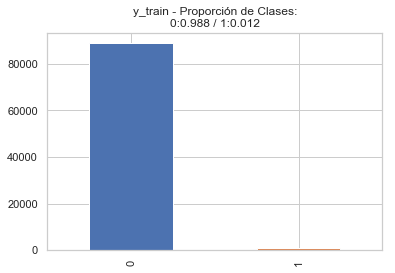

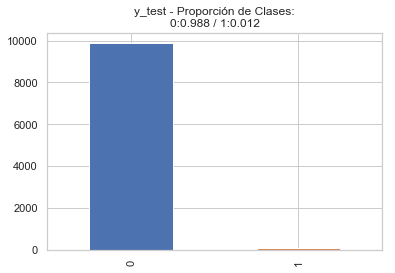

In [21]:
# Check distribución de clases entre train y test sets
plot_target_prop(y_train, tit='y_train')
plot_target_prop(y_test, tit='y_test')

#### Nuevo split train-test para validación

In [25]:
# Split manteniendo balance de clases en train y test para validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=RS, test_size=0.10)

In [68]:
X_train.shape
X_val.shape

(80999, 47)

(9000, 47)

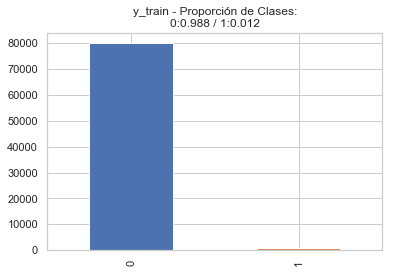

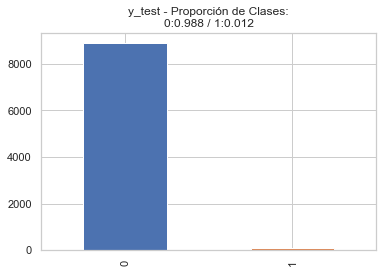

In [28]:
# Check distribución de clases entre train y test en validacion_
plot_target_prop(y_train, tit='y_train')
plot_target_prop(y_val, tit='y_test')

## Pipeline

In [29]:
preprocessing_nums = Pipeline([
    ('fillna',  SimpleImputer(strategy='median')),
    ('scaler',  RobustScaler())
])
preprocessing_cats = Pipeline([
    ('fillna',  SimpleImputer(missing_values='nan', strategy='most_frequent')),
    ('dummy',   OneHotEncoder(handle_unknown='ignore'))
])
preprocessing_dates = Pipeline([
    ('fromunix',  DatetimeFromUnixTimestamp()),
    ('encoder',   DateEncoder()),
    ('scaler',    RobustScaler())
])

preprocessing = ColumnTransformer([
    ('nums',  preprocessing_nums,  num_cols),
    ('cats',  preprocessing_cats,  cat_cols),
    ('dates', preprocessing_dates, date_cols)
],
    remainder='drop')

In [36]:
pipe = Pipeline([
    ('preprocessing', preprocessing),
    #('todense', SparseToDense()),
    ('resamp', SMOTEENN()),
    #('reducedim', PCA()),         
    ('featselect', RFECV(estimator=LinearRegression())),
    ('model', LogisticRegression(random_state=RS))], 
    memory='cachedir' )

In [38]:
params = [{
            #'preprocessing__nums__scaler': [StandardScaler(), RobustScaler()],
            'resamp': [None, SMOTEENN(random_state=RS)],#, SMOTETomek(), BorderlineSMOTE(), AllKNN()],
            #'reducedim': [None, PCA(random_state=RS)], # no admite sparse
            #'reducedim__n_components': [10, 25, 50],
            'featselect': [None, RFECV(estimator=LinearRegression())],#, SelectPercentile(percentile=25)],
            'model': [LogisticRegression(class_weight='balanced', random_state=RS)],
            'model__C': [1, 100, 10000],
          },
    
          #{
          #'model': [GaussianNB()], # no admite sparse
          #'reducedim': [None, PCA(5), PCA(10)],
          #'resamp': [SMOTEENN(), SMOTETomek()],
          #'preprocessing__nums__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
          #},
    
          #{
          #'model': [SVC(class_weight='balanced', kernel='rbf')],
          #'model__C': [1e2,1e3,1e4],
          #'model__gamma': [1e-4],
          #'reducedim': [None, PCA(50)],
          #'resamp': [SMOTEENN(), SMOTETomek()],
          #'preprocessing__nums__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
          #},

          #{
          #'model': [SVC(class_weight='balanced', kernel='linear')],
          #'model__C': [1e4],
          #'reducedim': [None, PCA(5), PCA(10)],
          #'resamp': [SMOTEENN(), SMOTETomek()],
          #'preprocessing__nums__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
          #},   
    
         ]

In [39]:
grid = GridSearchCV(estimator=pipe, param_grid=params, scoring='roc_auc', cv=2)
grid.fit(X_train, y_train)

/anaconda3/envs/DataScience36/lib/python3.6/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 9.94s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory='cachedir',
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('nums', Pipeline(memory=None,
     steps=[('fillna', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verb...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'resamp': [None, SMOTEENN(enn=None, random_state=None, ratio=None, sampling_strategy='auto',
     smote=None)], 'featselect': [None, RFECV(cv='warn',
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_job...e,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)], 'model__C': [1, 100, 10000]}],
       pre_dispatch='2*n_jobs',

In [83]:
# summarize results
print("Best: {:.4f} using {}".format(grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

Best: 0.7902 using {'featselect': None, 'model': LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False), 'model__C': 1, 'resamp': None}


In [84]:
results = pd.DataFrame([means, stds, params], index=['Media', 'Stdev', 'Params']).T
results = results.sort_values(by=['Media', 'Stdev'], ascending=[False, True])
results['Media']=results['Media'].map('{:,.4f}'.format)
results['Stdev']=results['Stdev'].map('{:,.4f}'.format)
results

,Media,Stdev,Params
0,0.7902,0.0004,"{'featselect': None, 'model': LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False), 'model__C': 1, 'resamp': None}"
6,0.7900,0.0003,"{'featselect': RFECV(cv='warn', estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0), 'model': LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False), 'model__C': 1, 'resamp': None}"
2,0.7883,0.0008,"{'featselect': None, 'model': LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False), 'model__C': 100, 'resamp': None}"
4,0.7883,0.0009,"{'featselect': None, 'model': LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False), 'model__C': 10000, 'resamp': None}"
8,0.7881,0.0005,"{'featselect': RFECV(cv='warn', estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0), 'model': LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False), 'model__C': 100, 'resamp': None}"
10,0.7881,0.0006,"{'featselect': RFECV(cv='warn', estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0), 'model': LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False), 'model__C': 10000, 'resamp': None}"
7,0.7847,0.0014,"{'featselect': RFECV(cv='warn', estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0), 'model': LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False), 'model__C': 1, 'resamp': SMOTEENN(enn=None, random_state=None, ratio=None, sampling_strategy='auto', smote=None)}"
1,0.7843,0.0010,"{'featselect': None, 'model': LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False), 'model__C': 1, 'resamp': SMOTEENN(enn=None, random_state=None, ratio=None, sampling_strategy='auto', smote=None)}"
3,0.7835,0.0010,"{'featselect': None, 'model': LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False), 'model__C': 100, 'resamp': SMOTEENN(enn=None, random_state=None, ratio=None, sampling_strategy='auto', smote=None)}"
5,0.7834,0.0010,"{'featselect': None, 'model': LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_i

In [91]:
# Guardar resultados de corrida en Train
#results.to_csv('run1.csv')

#### Evaluación del modelo en Validación

In [108]:
# Evaluacion del modelo para tunear threshold
p_pred = grid.predict_proba(X_val)[:, 1]  # sobre test set
y_pred = grid.predict(X_val)     
auc_test = roc_auc_score(y_val, p_pred)
auc_test

0.8263984047448614

#### Confusion Matrix

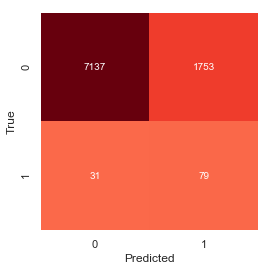

In [109]:
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Reds', center=True)
plt.xlabel('Predicted')
plt.ylabel('True');

#### ROC curve
It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.

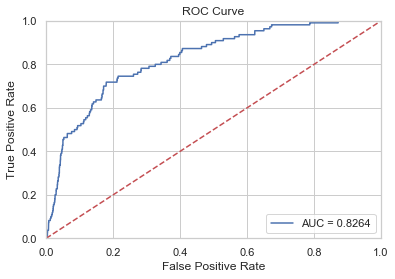

In [105]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, p_pred)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = {:0.4f}'.format(roc_auc))
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

#### Tuning del threshold

In [81]:
p_pred[:10]
y_pred[:10]

array([0.15869345, 0.27522352, 0.08134348, 0.44386677, 0.20023095,
       0.43847765, 0.39562663, 0.19284623, 0.1313127 , 0.73706908])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [73]:
y_pred_t = [1 if p_pred[i] > 0.5 else 0 for i in range(len(p_pred))]

In [76]:
all(y_pred == y_pred_t)

True

In [93]:
roc_auc_score(y_val, p_pred)

0.8263984047448614

In [77]:
def tune_threshold(prob, y_true, threshold=0.5):
    y_new = [1 if prob[i] > 0.5 else 0 for i in range(len(prob))]
    return roc_auc_score(pred, y_new)

### Evaluación del modelo en Test

In [107]:
# Evaluacion del modelo para tunear threshold
p_pred = grid.predict_proba(X_test)[:, 1]  # sobre test set
y_pred = grid.predict(X_test)     
auc_test = roc_auc_score(y_test, p_pred)
auc_test

0.7922610769419708